# Turning individual patient-level predictions into predictions of how many beds will be needed

In the previous notebook [4a_Predict_probability_of_admission_from_ED.ipynb](4a_Predict_probability_of_admission_from_ED.ipynb), we created a model that will generate a probability of admission for each individual patient in the ED or SDEC. Since the objective of this modelling is to predict number of beds needed for a group of patients in the ED at a prediction moment, this notebook shows how to convert the individual-level probabilities into aggregate predictions.

The patientflow python package includes a function called `get_prob_dist()` in a script called `aggregate.py` that will do the aggregating step. For each prediction moment, at which a set of patients were in ED or SDEC, this function generates a probability distribution showing how many beds will be needed by those patients. 

The function expects several inputs, including a dictionary - here called `snapshots_dict` - in which each key is a snapshot datetime and the values are an array of `snapshot_id` for each patient in the ED/SDEC at that snapshot datetime. 


## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()

Inferred project root: /Users/zellaking/Repos/patientflow


## Load parameters and set file paths, and load data

In [6]:
import pandas as pd
from patientflow.load import load_data, set_file_paths
from patientflow.prepare import create_temporal_splits


# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(project_root, 
               data_folder_name=data_folder_name)

# load data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

# get test set from the original data
_, _, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media
Split sizes: [53801, 6519, 19494]


## Generate aggregate predictions for one time of day 15:30 

In the previous step, shown in notebook [4a_Predict_probability_of_admission_from_ED.ipynb](4a_Predict_probability_of_admission_from_ED.ipynb), we trained five models, one for each prediction time. Here we'll focus on the 15:30 prediction time. 

The first step is to retrieve data on patients in the ED at that time of day, and use a saved model to make a prediction for each of them. 

The function in the cell below formats the name of the model based on the time of day

In [7]:
from patientflow.load import get_model_key
prediction_time = tuple([15,30])
model_name = 'admissions_balanced_calibrated'
model_key = get_model_key(model_name, prediction_time)
print(f'The name of the model to be loaded is {model_key}. It will be loaded from {model_file_path}')

The name of the model to be loaded is admissions_balanced_calibrated_1530. It will be loaded from /Users/zellaking/Repos/patientflow/trained-models/public


Next we use the `prepare_for_inference()` function. This does several things:

* loads the trained model into a variable called `model`
* reloads the original data, selects the test set records only and takes the subset of snaphots at 15:30 in the afternoon
* prepares this subset for input into the trained model, which is returned in a variable called `X_test`. (Note that here we are not using X_test for training the model, but for inference - inference means that we are asking atrained   model to make predictions. The model will expect the input data to be in the same format as it received when it was trained)
* returns an array of values `y_test` which is a binary variable whether each patient was actually admitted. This will be used to evaluate the model. 

In [21]:
from patientflow.prepare import prepare_for_inference

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','consultation_sequence', 'visit_number', 'specialty', 'final_sequence', 'training_validation_test']

X_test, y_test, pipeline = prepare_for_inference(
    model_file_path, 
    model_name,
    prediction_time,
    model_only=False,
    df=test_visits,
    single_snapshot_per_visit=False,
    exclude_from_training_data=exclude_from_training_data)

We can also view the data that was loaded for running inference on the model

In [11]:
X_test.head()

,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,num_obs_events,num_obs_types,num_lab_batteries_ordered,...,latest_lab_results_crea,latest_lab_results_hctu,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt
snapshot_id,,,,,,,,,,,,,,,,,,,,,
2,9180,M,75-102,NaN,majors,4,127,12,37,8,...,97.0,0.483,4.1,1.2,140.0,4.82,7.433,6.59,NaN,NaN
59741,25080,F,18-24,NaN,sdec,5,10,1,10,5,...,79.0,0.375,3.9,NaN,140.0,NaN,NaN,8.41,39.0,NaN
60002,11160,F,65-74,NaN,sdec_waiting,4,14,2,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60261,16680,F,35-44,NaN,sdec_waiting,3,20,2,20,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60278,24060,F,75-102,Ambulance,majors,5,67,7,27,8,...,71.0,0.421,4.4,1.2,138.0,6.44,7.394,5.48,NaN,NaN


Next we prepare a dictionary of snapshots (which is the term used here to refer to moments in time when we want to make predictions). The key for each dictionary entry is a snapshot datetime. The values are snapshot_ids for patients in the ED or SDEC at that time.

The output of the following cell shows the first 10 keys, and the first set of values - simply a list of snapshot_ids

In [16]:
from patientflow.prepare import prepare_snapshots_dict

# select the snapshots to include in the probability distribution, 
snapshots_dict = prepare_snapshots_dict(
    test_visits[test_visits.prediction_time == prediction_time]
    )

print("First 10 keys in the snapshots dictionary")
print(list(snapshots_dict.keys())[0:10])

first_record_key = list(snapshots_dict.keys())[0]
first_record_values = snapshots_dict[first_record_key]

print("\nRecord associated with the first key")
print(first_record_values)

First 10 keys in the snapshots dictionary
['10/1/2031', '10/10/2031', '10/11/2031', '10/12/2031', '10/13/2031', '10/14/2031', '10/15/2031', '10/16/2031', '10/17/2031', '10/18/2031']

Record associated with the first key
[59741, 60002, 60261, 60278, 60317, 60324, 60335, 60351, 60358, 60363, 60375, 60380, 60383, 60385, 60387, 60389, 60400, 60405, 60408, 60409, 60410, 60411, 60412, 60413, 60414, 60415, 60416, 60417, 60418, 60419, 60420, 60421, 60422, 60423, 60424, 60425, 60426, 60427, 60428, 60429, 60430, 60431, 60432, 60433, 60434, 60435, 60436, 60437, 60438, 60443, 60444, 60445, 60448, 60449, 60451, 60452, 60453, 60454, 60455, 60456]


To see the snapshots associated with this first key in the snapshots dictionary, use the values it returns to retrieve the relevant rows in the original visits dataset.

In [17]:
ed_visits.loc[first_record_values].head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
59741,10/1/2031,"(15, 30)",135639,25080,F,18-24,NaN,sdec,5,10,...,NaN,NaN,8.41,39.0,NaN,test,['medical'],True,15383,medical
60002,10/1/2031,"(15, 30)",135923,11160,F,65-74,NaN,sdec_waiting,4,14,...,NaN,NaN,NaN,NaN,NaN,test,['ambulatory'],False,71795,NaN
60261,10/1/2031,"(15, 30)",136201,16680,F,35-44,NaN,sdec_waiting,3,20,...,NaN,NaN,NaN,NaN,NaN,test,['ambulatory'],False,200,NaN
60278,10/1/2031,"(15, 30)",136221,24060,F,75-102,Ambulance,majors,5,67,...,6.44,7.394,5.48,NaN,NaN,test,['acute'],True,37734,medical
60317,10/1/2031,"(15, 30)",136275,51810,M,45-54,NaN,sdec,12,84,...,NaN,NaN,NaN,NaN,NaN,test,['surgical'],False,21593,NaN


The following cell shows the number of patients who were in the ED at that snapshot datetime

In [18]:
print(len(ed_visits.loc[first_record_values]))

60


With the model, the snapshot dictionary, X_test and y_test as inputs, the get_prob_dist() function is called. It returns a dictionary, with the same keys as before, and with a probability distribution for each snapshot date in the test set. As this processes each snapshot date separately, it may take some time. 

In [22]:
from patientflow.aggregate import get_prob_dist
# get probability distribution for this time of day
prob_dist = get_prob_dist(
        snapshots_dict, X_test, y_test, pipeline
    )

Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates


The cell below shows the entry in the `prob_dist` dictionary (which is the first snapshot date in the test set) and the probability distribution associated with that date. 

In [23]:

print("First key in the prob dist dictionary")
print(list(prob_dist.keys())[0])

print("Probability distribution for first snapshot datetime")
prob_dist[first_record_key]

First key in the prob dist dictionary
10/1/2031
Probability distribution for first snapshot datetime


{'agg_predicted':                agg_proba
 0    3.83000095709416e-8
 1    8.91447105034246e-7
 2    9.96474713480853e-6
 3    7.12986776280389e-5
 4   0.000367215548706615
 ..                   ...
 56  2.70016724906273e-41
 57  2.17495414369041e-43
 58  1.27411141069909e-45
 59  4.82803167661050e-48
 60  8.88078644945381e-51
 
 [61 rows x 1 columns],
 'agg_observed': 11}

To make this output more readable, we can redisplay it like this

In [24]:
first_date_prob_dist = prob_dist[first_record_key]['agg_predicted'].rename(columns = {'agg_proba': 'probability'})
first_date_prob_dist.index.name = 'number of beds'

print(f"Probability of needing this number of beds on {first_record_key} at {prediction_time} based on EHR data from patients in the ED at that time")
display(first_date_prob_dist.head(15))


Probability of needing this number of beds on 10/1/2031 at (15, 30) based on EHR data from patients in the ED at that time


,probability
number of beds,
0,3.83000095709416e-8
1,8.91447105034246e-7
2,9.96474713480853e-6
3,7.12986776280389e-5
4,0.000367215548706615
5,0.00145156182973333
6,0.00458531140812794
7,0.0119004455059500
8,0.0258924729749449


We can plot this probability distribution using a function from the patientflow package

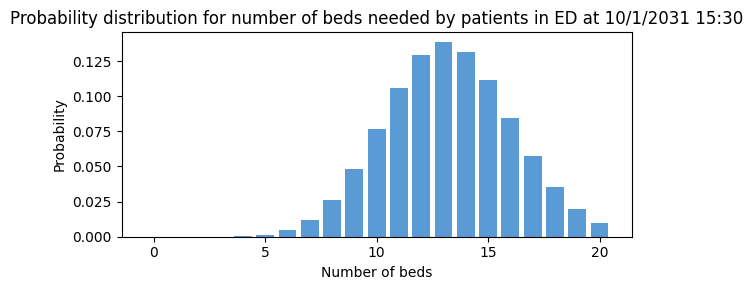

In [27]:
from patientflow.viz.prob_dist_plot import prob_dist_plot

title_ = f'Probability distribution for number of beds needed by patients in ED at {first_record_key} {prediction_time[0]:02d}:{prediction_time[1]:02d}'
prob_dist_plot(prob_dist_data=prob_dist[first_record_key]['agg_predicted'], 
    title=title_,  
    include_titles=True)

From the output above, we can see how many beds are predicted to be needed by the patients in the ED/SDEC at this particular snapshot. It gives a range of probability, rather than a single estimate. In a later notebook [5_Evaluate_model_performance.ipynb](5_Evaluate_model_performance.ipynb) we show how to evaluate the model's predictions. 

### Reading a minimum number of beds needed from the probability distribution

Our input for the UCLH output does not show a probability distribution like this. It shows 'at least this number of beds needed' with 90% and 70% probability. (Check back to notebook 2 for this). To calculate this from the distribution given, we illustrate first by added a cumulative probability to the dataframe created earlier.

In [28]:
first_date_prob_dist['cumulative probability'] = first_date_prob_dist['probability'].cumsum()
first_date_prob_dist['probability of needing at least this number or beds'] = first_date_prob_dist['cumulative probability'].apply(lambda x: 1 -x)
display(first_date_prob_dist.head(20))

,probability,cumulative probability,probability of needing at least this number or beds
number of beds,,,
0,3.83000095709416e-8,3.83000095709416e-8,0.999999961699990
1,8.91447105034246e-7,9.29747114605188e-7,0.999999070252885
2,9.96474713480853e-6,1.08944942494137e-5,0.999989105505751
3,7.12986776280389e-5,8.21931718774526e-5,0.999917806828123
4,0.000367215548706615,0.000449408720584068,0.999550591279416
5,0.00145156182973333,0.00190097055031739,0.998099029449683
6,0.00458531140812794,0.00648628195844533,0.993513718041555
7,0.0119004455059500,0.0183867274643953,0.981613272535605
8,0.0258924729749449,0.0442792004393402,0.955720799560660


From this cumulative probability we can read off the number of beds where there is a 90% chance of needing at least this number


In [29]:
row_indicating_at_least_90_pc = first_date_prob_dist[first_date_prob_dist['probability of needing at least this number or beds'] < 0.9].index[0]
print(f"There is a 90% chance of needing at least {row_indicating_at_least_90_pc} beds")

There is a 90% chance of needing at least 10 beds


The predict module has a function for reading off the cdf in this way 

In [30]:
from patientflow.predict.emergency_demand import index_of_sum
??index_of_sum

Signature: index_of_sum(sequence: List[float], max_sum: float) -> int
Source:   
def index_of_sum(sequence: List[float], max_sum: float) -> int:
    """Returns the index where the cumulative sum of a sequence of probabilities exceeds max_sum."""
    cumulative_sum = 0.0
    for i, value in enumerate(sequence):
        cumulative_sum += value
        if cumulative_sum >= 1 - max_sum:
            return i
    return len(sequence) - 1  # Return the last index if the sum doesn't exceed max_sum
File:      ~/Repos/patientflow/src/patientflow/predict/emergency_demand.py
Type:      function

In [31]:
sequence = first_date_prob_dist['probability'].values
print(f"There is a 90% chance of needing at least {index_of_sum(sequence, 0.9)} beds, using the index_of_sum function")


There is a 90% chance of needing at least 10 beds, using the index_of_sum function


And this can be done from the original probability distribution

In [32]:
sequence = prob_dist[first_record_key]['agg_predicted']['agg_proba'].values
cdf_cut_points = [0.9, 0.7]
for cut_point in cdf_cut_points:
    num_beds = index_of_sum(sequence, cut_point)
    print(f"At least {num_beds} beds needed with {int(cut_point*100)}% probability")


At least 10 beds needed with 90% probability
At least 12 beds needed with 70% probability
